Since clustering takes longer than classifying and regression, we decide to switch to a 0.7 - 0.15 - 0.15 split of train-val-test. The aim being to try finding the best model by trying it out on the validation set first and then on the test set. since we have near 100,000 points in total, we can reduce the training set slightly.

In [1]:
# basics
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
from sklearn.pipeline import Pipeline

# creating train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# classifiers
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# evaluating models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score


# regressors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge

# optimising models and fine tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# unsupervised learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# dimensionality reduction
from sklearn.decomposition import PCA

In [7]:
def get_train_test():
    
    '''GET DATASET FROM CSV FILE, REMOVE OUTLIERS AND DROP USELESS COLUMNS,
    ONLY KEEP FILTERS AND REDSHIFTS OF GALAXIES!! (IGNORE OTHER OBJECTS)'''
    
    # load
    df = pd.read_csv("star_classification.csv")
    # remove outliers (we noticed some objects had values for u/z/g/redshift below zero)
    outliers = df[(df["u"] <= 0)  
                | (df["z"] <= 0) 
                | (df["g"] <= 0)]

    # drop the row corresponding to the outlier
    df = df.drop(outliers.index, axis=0)
    
    # we drop the data we are not interested in and which won't be useful
    # expect isotropic universe -> also drop position in sky
    df = df.drop(
        columns=["alpha", "delta", "obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
                 "field_ID", "cam_col", "rerun_ID", "run_ID"], axis=1)
    
    # replace and drop all NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(axis=0)
    
    # stratified split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_val_index, test_index in split.split(df, df["class"]):
        strat_train_val_set = df.loc[train_val_index]
        strat_test_set = df.loc[test_index]
    
    # replace and drop all NaN
    strat_train_val_set = strat_train_val_set.reset_index(drop=True)
    strat_train_val_set = strat_train_val_set.replace([np.inf, -np.inf], np.nan)
    strat_train_val_set = strat_train_val_set.dropna(axis=0)
    
    # stratified split
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_index, val_index in split.split(strat_train_val_set, strat_train_val_set["class"]):
        strat_train_set = strat_train_val_set.loc[train_index]
        strat_val_set = strat_train_val_set.loc[val_index]
    
    return strat_train_set, strat_test_set, strat_val_set, df

train, test, val, df = get_train_test()

# replace and drop all NaN
train = train.reset_index(drop=True)
train = train.replace([np.inf, -np.inf], np.nan)
train = train.dropna(axis=0)

# replace and drop all NaN
test = test.reset_index(drop=True)
test = test.replace([np.inf, -np.inf], np.nan)
test = test.dropna(axis=0)

# replace and drop all NaN
val = val.reset_index(drop=True)
val = val.replace([np.inf, -np.inf], np.nan)
val = val.dropna(axis=0)

# seperate measurements (x) with class(y) in train set
x_train = train.drop(columns=["class"], axis=1)
y_train = train["class"]

# seperate measurements (x) with class(y) in val set
x_val = val.drop(columns=["class"], axis=1)
y_val = val["class"]

# seperate measurements (x) with class(y) in test set
x_test = test.drop(columns=["class"], axis=1)
y_test = test["class"]

In [8]:
y_train_galaxy = (y_train == "GALAXY")
y_test_galaxy = (y_test == "GALAXY")

In [9]:
# whole dataset 
x = df.drop(columns = "class")
y = df["class"]

## Attempting dimensionality reduction down to 2D/3D

## Clustering: K-Means

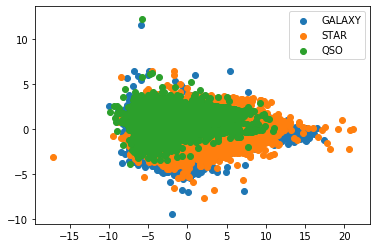

In [12]:
pca = PCA(n_components = 2)
x_reduced = pca.fit_transform(x_train)
x = x_reduced[:, 0]
y = x_reduced[:, 1]

train["x_reduced"] = x
train["y_reduced"] = y

for name in train["class"].unique():
    train_temp = train[train["class"] == name]
    plt.scatter(train_temp.x_reduced.values, train_temp.y_reduced.values, alpha=1, label=name)
    plt.legend()
    

## Clustering: TSNE

In [30]:
from sklearn.manifold import TSNE

x_train_np = np.asarray(x_train, dtype='float64')

x_embedded = TSNE(n_components=2,
                  init='random', perplexity=3).fit_transform(x_train_np)
x_embedded.shape

(79998, 2)

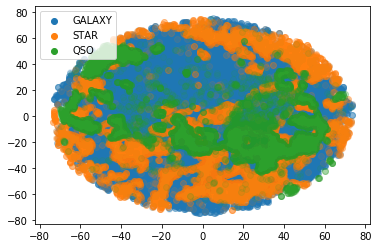

In [33]:
x = x_embedded[:, 0]
y = x_embedded[:, 1]

train["x_reduced"] = x
train["y_reduced"] = y

for name in train["class"].unique():
    train_temp = train[train["class"] == name]
    plt.scatter(train_temp.x_reduced.values, train_temp.y_reduced.values, alpha=0.1, label=name)

leg = plt.legend()    
for lh in leg.legendHandles: 
        lh.set_alpha(1)

## Clustering: UMAP

Decent initial clustering -> trying to improve using https://umap-learn.readthedocs.io/en/latest/parameters.html

In [7]:
%pip install --user umap-learn

  Using cached https://files.pythonhosted.org/packages/ce/f7/2b46d242b412f5780e53d42bbd440d8a8c9d092c76d4688e9feae0e09bc1/numba-0.56.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/9d/20/0ffe8665a44bce7616bd33d4368a198fecad3b226bcafa38c63ef0f6286f/scikit_learn-1.0.2-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/4a/ee/0a45f7aee67c9e51c0c5c18a5689766fc2b4365cc8d140668ff870876ff3/llvmlite-0.39.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/61/cf/6e354304bcb9c6413c4e02a747b600061c21d38ba51e7e544ac7bc66aecc/threadpoolctl-3.1.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [10]:
import umap
def plot_umap(n_neighbors=15,min_dist=0.1, n_components=2, metric='euclidean', title=''):
    x_train_np = np.asarray(x_train, dtype='float64')
    standard_embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric, random_state=42).fit_transform(x_train_np)

    x = standard_embedding[:, 0]
    y = standard_embedding[:, 1]

    train["x_reduced"] = x
    train["y_reduced"] = y

    for name in train["class"].unique():
        train_temp = train[train["class"] == name]
        plt.scatter(train_temp.x_reduced.values, train_temp.y_reduced.values, alpha=0.05, label=name)
    
    plt.title(title)
    leg = plt.legend()    
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

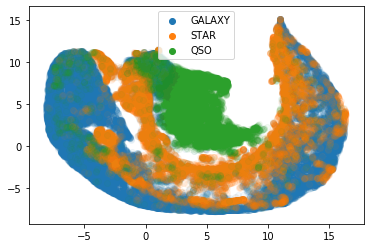

In [9]:
plot_umap()

C:\Users\ellio\AppData\Roaming\Python\Python37\site-packages\pynndescent\pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


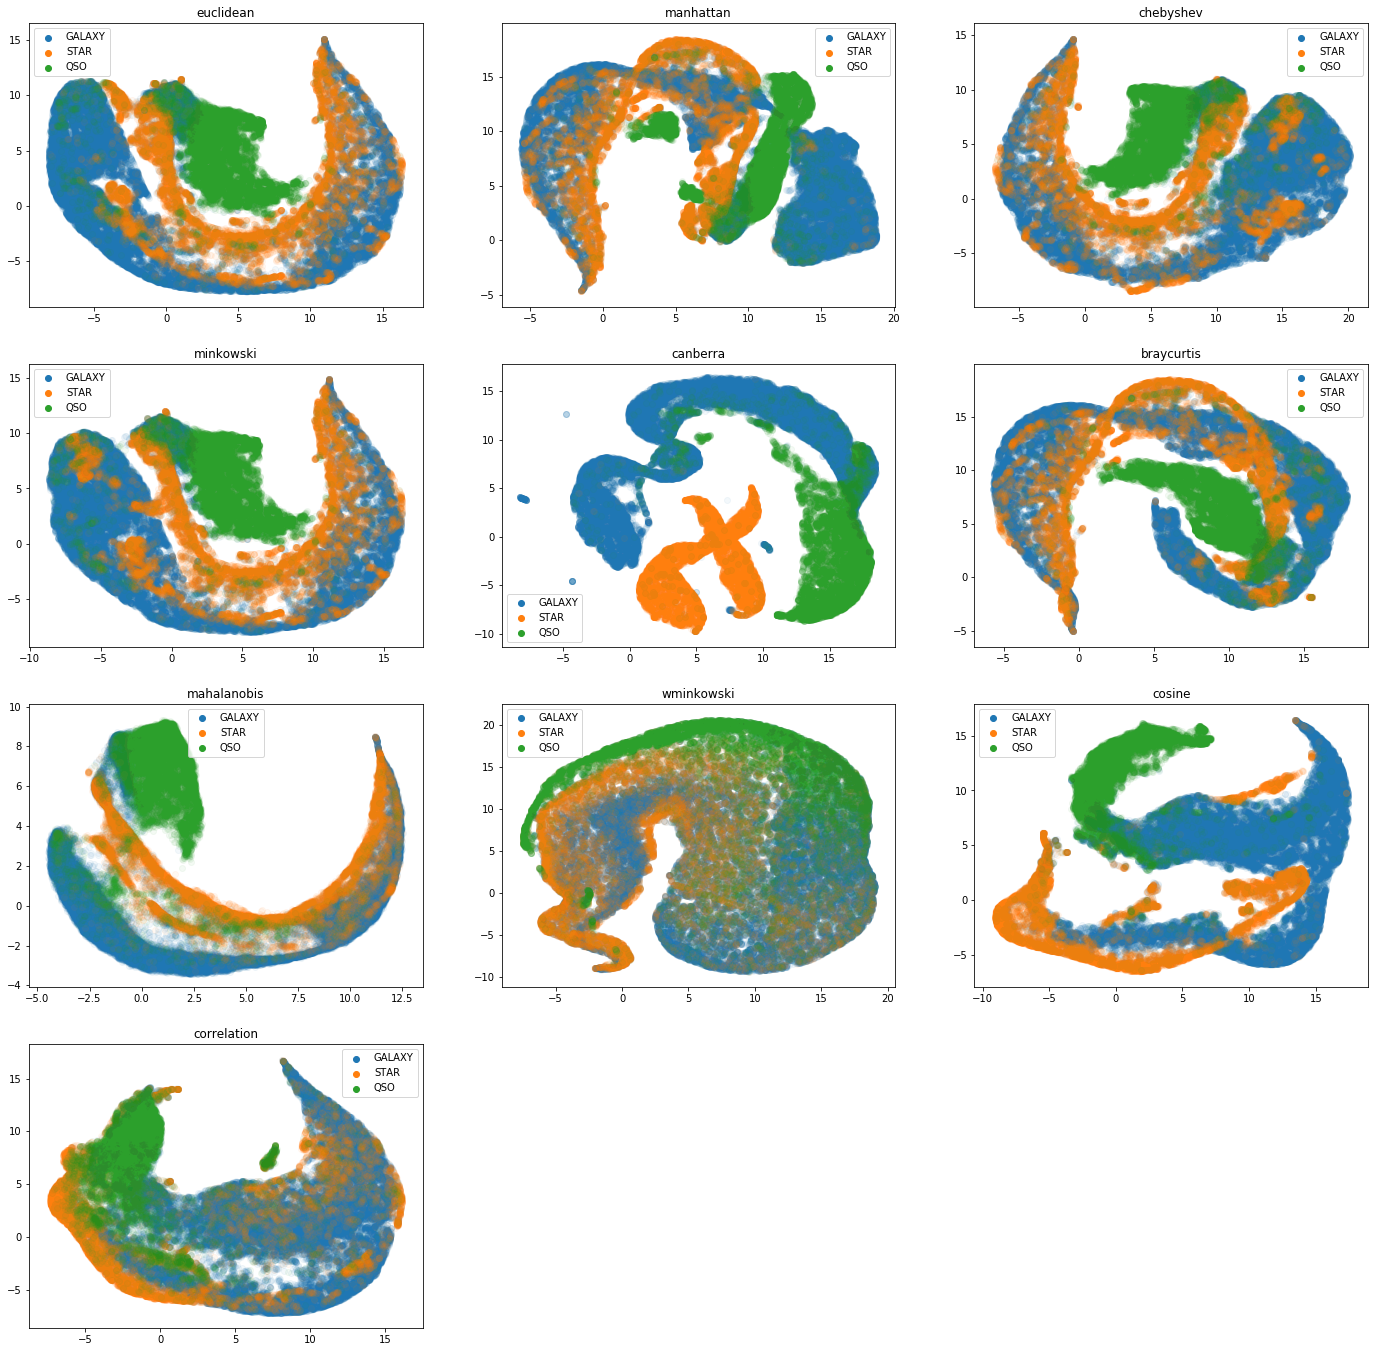

In [56]:
plt.figure(figsize=[24,24])
count=1
for m in ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'canberra', 'braycurtis', 'mahalanobis', 'wminkowski', 'cosine', 'correlation']:
    plt.subplot(4,3,count)
    plot_umap(15, 0.1, 2, m, m)
    count+=1

plt.show()

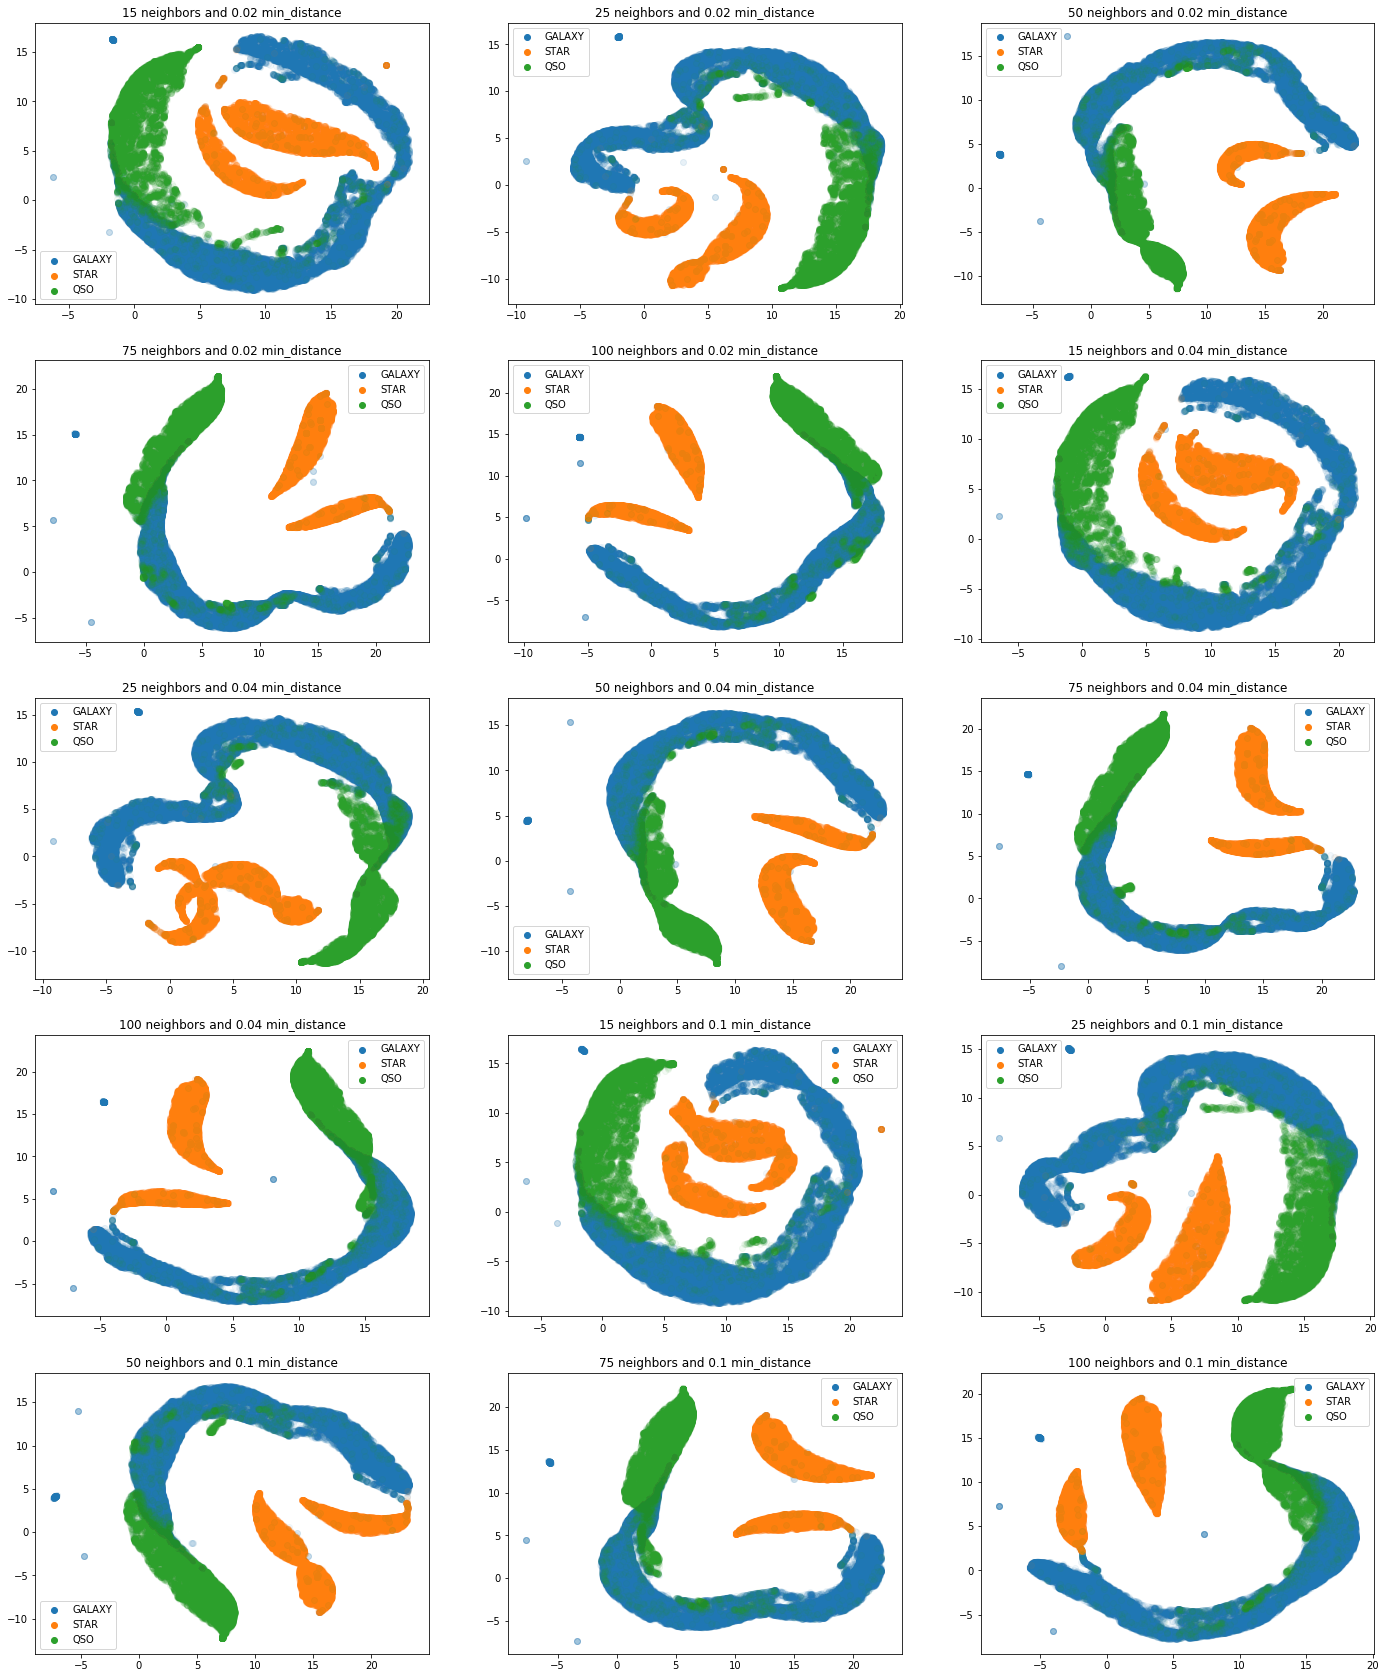

In [11]:
plt.figure(figsize=[24,30])
count=1
for d in [0.02, 0.04, 0.1]:
    for n in [15, 25, 50, 75, 100]:
        plt.subplot(5,3,count)
        plot_umap(n, d, 2, 'canberra', "{n} neighbors and {d} min_distance".format(n=n, d=d))
        count+=1

plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


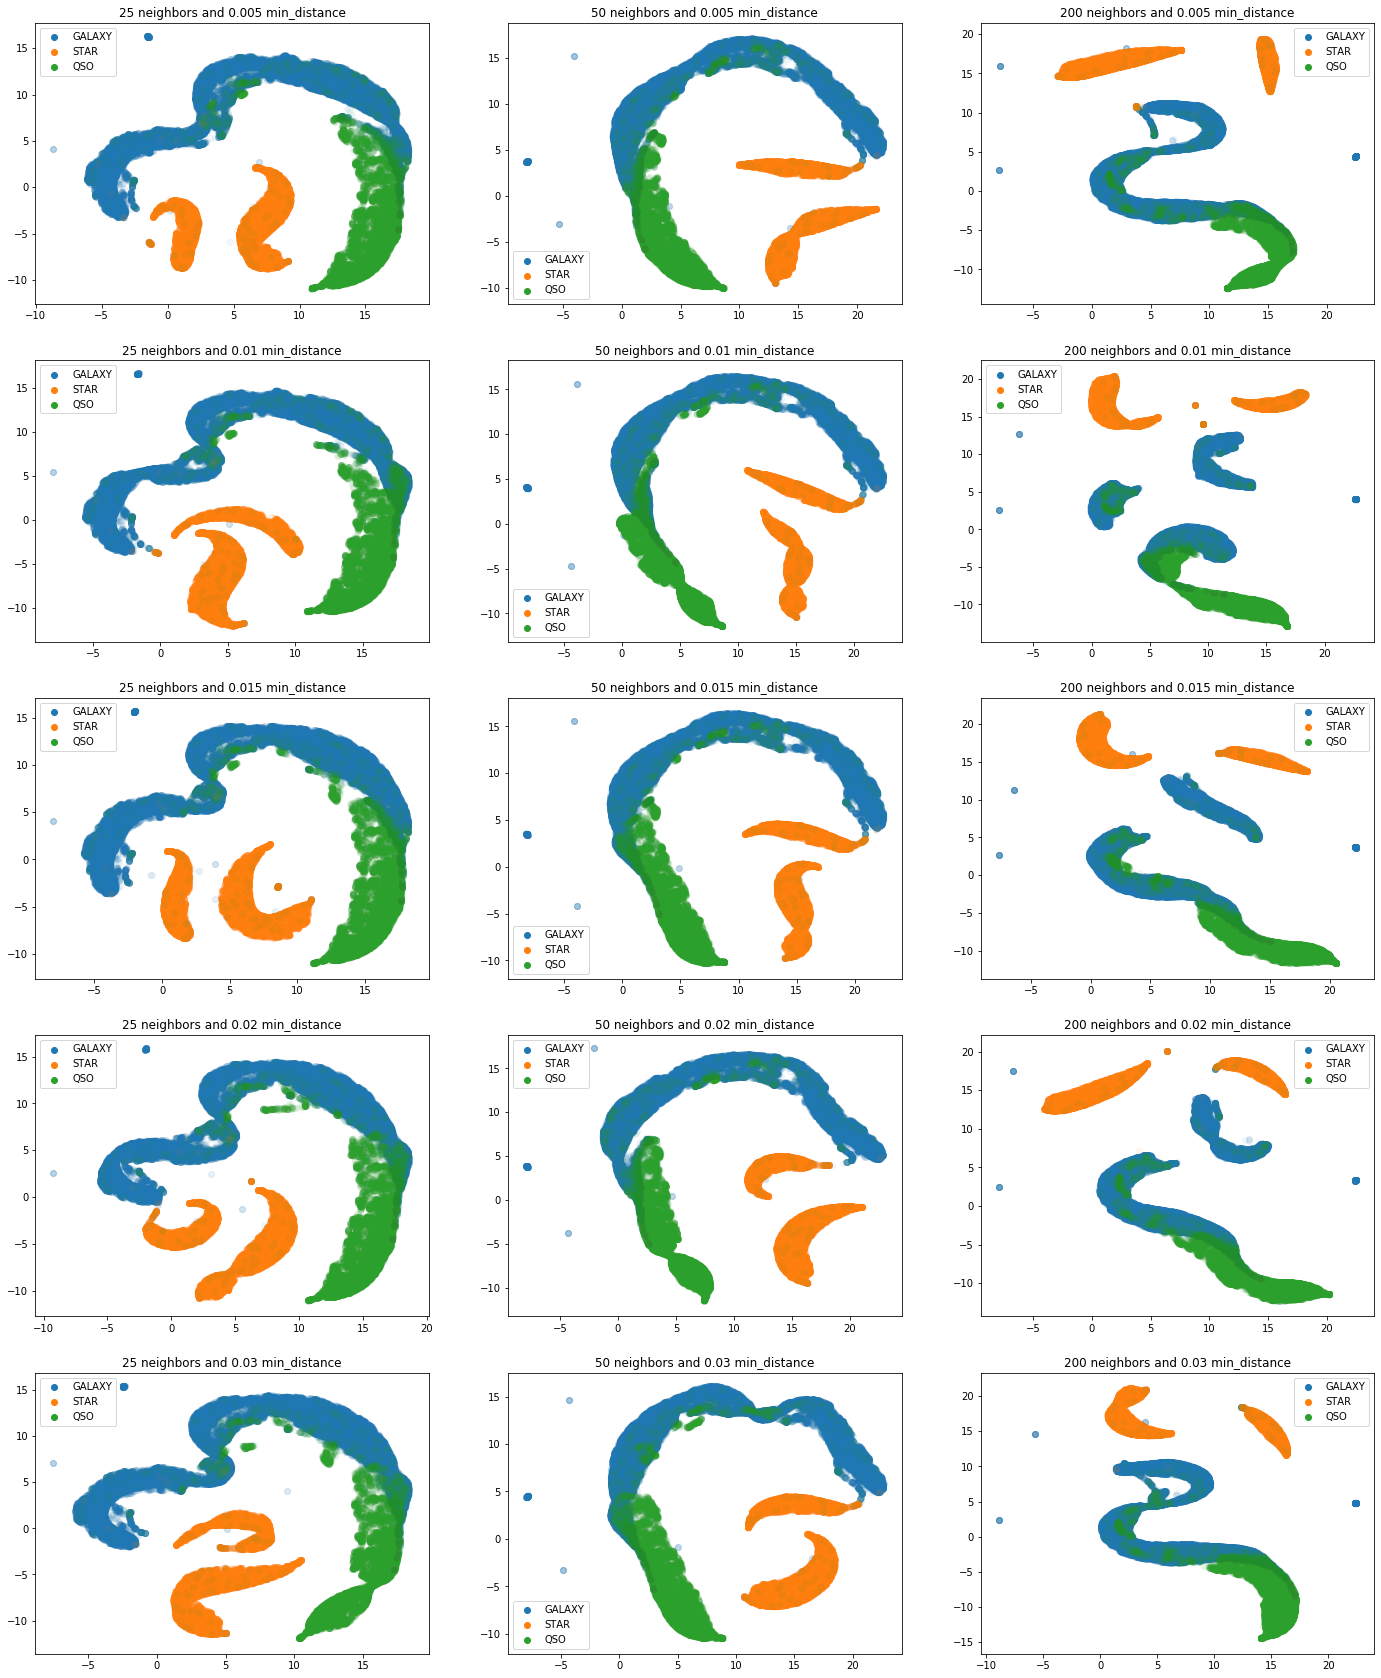

In [13]:
plt.figure(figsize=[24,30])
count=1
for d in [0.005, 0.01, 0.015, 0.02, 0.03]:
    for n in [25, 50, 200]:
        plt.subplot(5,3,count)
        plot_umap(n, d, 2, 'canberra', "{n} neighbors and {d} min_distance".format(n=n, d=d))
        print(count)
        count+=1

plt.show()

1
2
3


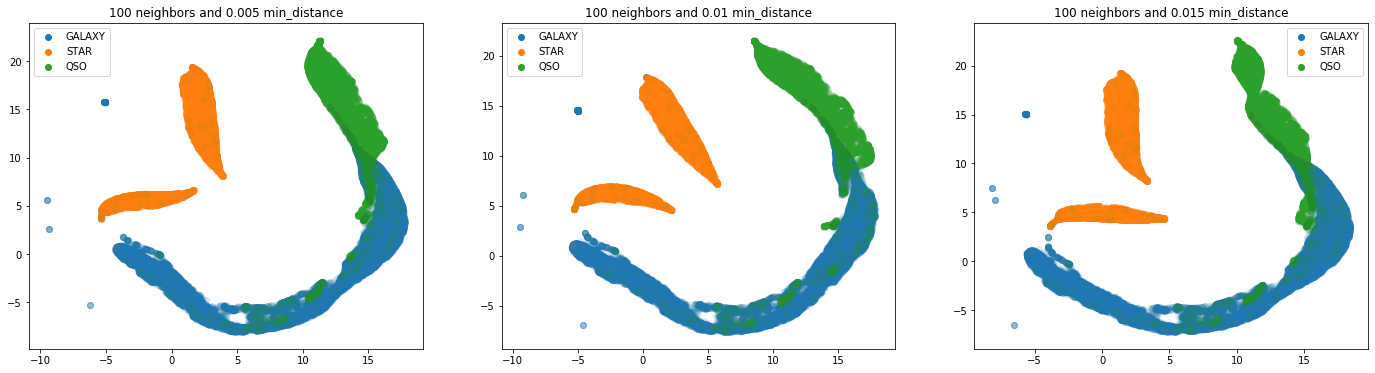

In [31]:
plt.figure(figsize=[24,6])
count=1
for d in [0.005, 0.01, 0.015]:
    for n in [100]:
        plt.subplot(1,3,count)
        plot_umap(n, d, 2, 'canberra', "{n} neighbors and {d} min_distance".format(n=n, d=d))
        print(count)
        count+=1

plt.show()

### Checking different models on validation set

In [27]:
def plot_val_umap(n_neighbors=15,min_dist=0.1, n_components=2, metric='euclidean', title=''):
    x_train_np = np.asarray(x_train, dtype='float64')
    umap_fit = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric, random_state=42).fit(x_train_np)

    x_val_np = np.asarray(x_val, dtype='float64')
    val_transf = umap_fit.transform(x_val_np)

    x = val_transf[:, 0]
    y = val_transf[:, 1]

    val["x_reduced"] = x
    val["y_reduced"] = y

    plt.figure(figsize=[12,10])
    plt.title(title)

    for name in val["class"].unique():
        val_temp = val[val["class"] == name]
        plt.scatter(val_temp.x_reduced.values, val_temp.y_reduced.values, alpha=0.05, label=name)
        leg = plt.legend()    
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

#### 1. n_neighbors=25, min_dist=0.015, n_components=2, metric='canberra'

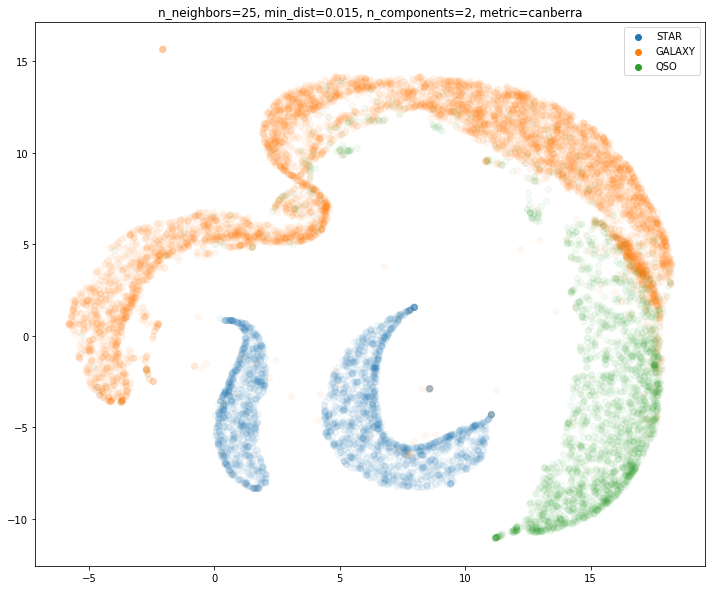

In [30]:
plot_val_umap(n_neighbors=25, min_dist=0.015, n_components=2, metric='canberra', title="n_neighbors=25, min_dist=0.015, n_components=2, metric='canberra'")

#### 2. n_neighbors=25, min_dist=0.015, n_components=2, metric='canberra'

## Clustering for preprocessing

Applying simple Logistic Regression to see the accuracy score:

In [84]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(x_train, y_train_galaxy)
print("cross-val score:", cross_val_score(log_reg,x_train, y_train_galaxy, cv=3).mean())
log_reg.score(x_test, y_test_galaxy)

cross-val score: 0.8257706562915007


0.8216

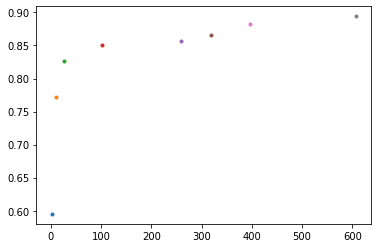

In [85]:
for n in [2,5,10,25,50,75,100,150]:
    
    pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=n)),
    ("log_reg", LogisticRegression()),
    ])
    
    start_time = time.time()
    score = cross_val_score(pipeline, x_train, y_train_galaxy, cv=3).mean()
    delta_t = time.time() - start_time
    plt.plot(delta_t, score, '.')

#param_grid = dict(kmeans__n_clusters=[100])
#grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
#grid_clf.fit(x_train, y_train)

#print(grid_clf.best_params_)
#print(grid_clf.score(x_test, y_test))

In [ ]:
pipeline = Pipeline([
("kmeans", KMeans(n_clusters=150)),
("log_reg", LogisticRegression(random_state=42)),
])

param_grid = {'log_reg__C': [0.9, 1, 1.1],
               'log_reg__max_iter': [75,100,125],
               'log_reg__verbose': [0,1,2]}

grid_search = GridSearchCV(pipeline, param_grid, cv=3)
grid_search.fit(x_train, y_train_galaxy)

grid_search.best_params_

[LibLinear]

## Clustering for preprocessing: Random Forest

In [83]:
rf_clf = RandomForestClassifier(n_estimators=150, min_samples_split=2, min_samples_leaf=4,
                                    min_weight_fraction_leaf=0, max_features=3, random_state=42)
rf_clf.fit(x_train, y_train_galaxy)
rf_clf.score(x_test, y_test_galaxy)

0.97935

In [60]:
score_train = []
score_test = []

for n in [2,5,10,25,50,75,100]:
    
    pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=n)),
    ("rf_clf", RandomForestClassifier(n_estimators=150, min_samples_split=2, min_samples_leaf=4,
                                      min_weight_fraction_leaf=0, max_features=2, random_state=42)),
    ])
    
    start_time = time.time()
    pipeline.fit(x_train, y_train)
    score_test = np.append(score_test, pipeline.score(x_test, y_test))
    score_train = np.append(score_train, cross_val_score(pipeline,x_train, y_train, cv=3).mean())
    delta_t = time.time() - start_time
    print("ok")
    
plt.plot(delta_t, score_train, '.', label="cross-val score")
plt.plot(delta_t, score_test, '.', label="test score")
plt.legend()
plt.show()

KeyboardInterrupt: 

## Clustering for preprocessing: Decision Tree

In [65]:
dt_clf = DecisionTreeClassifier(max_features=5, min_impurity_decrease=0,min_samples_leaf=25,
                                min_weight_fraction_leaf=0, random_state=42)
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.97585

ok
ok
ok
ok
ok
ok
ok


ValueError: x and y must have same first dimension, but have shapes (1,) and (7,)

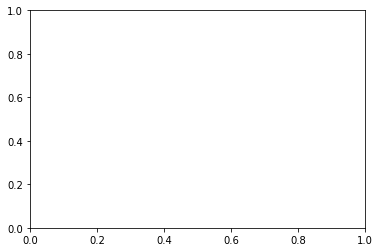

In [72]:
score_train = []
score_test = []
for n in [2,5,10,25,50,75,100]:
    
    pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=n)),
    ("rf_clf", DecisionTreeClassifier(max_features=2, min_impurity_decrease=0,min_samples_leaf=25,
                                min_weight_fraction_leaf=0, random_state=42)),
    ])
    
    start_time = time.time()
    pipeline.fit(x_train, y_train)
    score_test = np.append(score_test, pipeline.score(x_test, y_test))
    score_train = np.append(score_train, cross_val_score(pipeline,x_train, y_train, cv=3).mean())
    delta_t = time.time() - start_time
    print("ok")
    
plt.plot(delta_t, score_train, '.', label="cross-val score")
plt.plot(delta_t, score_test, '.', label="test score")
plt.legend()
plt.show()

In [75]:
score_test

array([0.66365, 0.7864 , 0.8154 , 0.84585, 0.8595 , 0.85655, 0.86105])

### Analysing silhouette score with different clustering numbers

Do i need to use the whole dataset? or split into training and testing??

KeyboardInterrupt: 

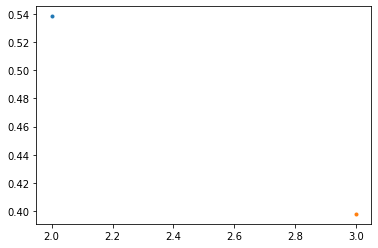

In [31]:
for k in [2,3,4,5,6]:
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(x_train)
    plt.plot(k, silhouette_score(x_train, kmeans.labels_), '.')

## Attempting Neural Network

In [ ]:
model = keras.models.Sequential([
    keras.layers.(input_shape=[5]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])